In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import time
import datetime as dt
import psutil
from PIL import Image
import matplotlib.pyplot as plt
from random import shuffle
import glob
import pickle
import torchvision
from torch.optim import lr_scheduler
import torch.nn.functional as F

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
def no_of_params(model):
    sum_ = 0.
    for key, value in model.state_dict().items():
        sum_ += torch.prod(torch.tensor(value.shape))
        #print(value, "----------", torch.prod(torch.tensor(value.shape)))
    return int(sum_)

In [76]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        list_IDs,
    ):
        self.list_IDs  = list_IDs
        self.cache     = {}
        self.input_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_3/images/"
        self.label_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_3/labels/"
        
    def __len__(self):
        return len(self.list_IDs)
    
    def __getitem__(self, index):
        ID = self.list_IDs[index]
        if ID in self.cache:
            X = self.cache[ID]['X']
            Y = self.cache[ID]['Y']
        else:
            X = torchvision.io.read_image(
                self.input_dir + str(ID) + ".png "
            ).to(torch.float32)
            X = X[1].unsqueeze(0)/256.
            
            with open(self.label_dir + str(ID), 'rb') as fb:
                Y  = pickle.load(fb)
                
            #Y = [ (i + 3.)/6. for i in Y[0] ] + [i/3.14 for i in Y[1]]
            #Y = [ i/3. for i in Y[0] ] + [i/3.14 for i in Y[1]]
            
            Y = Y[0][1]/2.#/3.1415926
            Y = torch.tensor( Y, dtype=torch.float32 ).unsqueeze(0)
            
            if psutil.virtual_memory().percent < 50:
                data = {
                    'X' : X,
                    'Y' : Y
                }
                self.cache[ID] = data
        return X,Y

In [77]:
all_ids = [str(i) for i in  list(np.arange(0,1000,1))]
train_ids = all_ids[:800]
val_ids   = all_ids[800:]
params = {
    'batch_size'  : 32,
    'shuffle'     : True,
    #'num_workers' : 2
}
training_set         = Dataset(train_ids)
training_generator   = torch.utils.data.DataLoader(
                            training_set,
                            **params,
                            pin_memory=True
                        )
validation_set       = Dataset(val_ids)
validation_generator = torch.utils.data.DataLoader(
                            validation_set,
                            **params,
                            pin_memory=True
                        )

In [78]:
for batch in training_generator:
    break
batch[0].shape

torch.Size([32, 1, 32, 32])

tensor([-0.3797])

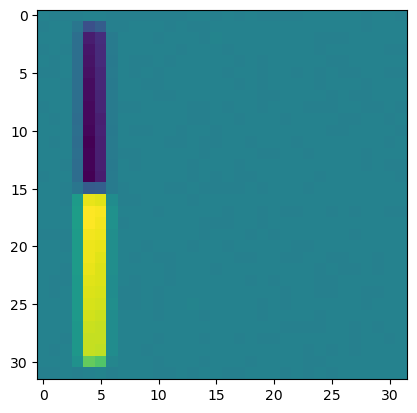

In [79]:
i = 3
plt.imshow(batch[0][i][0])
batch[1][i]

In [80]:
def train_one_epoch(
    model,
    optimizer
):
    running_loss = 0.
    loss_fn = nn.MSELoss()
    
    model.train(True)
    
    for i,batch in enumerate(training_generator):
        X = batch[0]
        Y = batch[1]
        output = model(batch[0])
        loss = loss_fn(Y, output)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        del X,Y,output
    
    return running_loss/(i+1)

def validate_one_epoch(
    model,
    optimizer
):
    running_loss = 0.
    loss_fn = nn.MSELoss()
    model.train(False)
    model.eval()
    
    for i,batch in enumerate(validation_generator):
        X = batch[0]
        Y = batch[1]
        output = model(batch[0])
        loss = loss_fn(Y, output)
        #optimizer.step()
        
        running_loss += loss.item()
        del X,Y,output
    
    return running_loss/(i+1)

In [81]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(3)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(24*10*10, 1)

    def forward(self, input):
        output = torch.tanh(self.bn1(self.conv1(input)))      
        output = torch.tanh(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = torch.tanh(self.bn4(self.conv4(output)))     
        output = torch.tanh(self.bn5(self.conv5(output))) 
        output = output.view(-1, 24*10*10)
        output = self.fc1(output)
        output = torch.tanh(output)

        return output

In [82]:
model = Network()
no_of_params(model)

25295

In [83]:
lr = 1e-5
wd = 1e-4
epochs = 10
optimizer = torch.optim.Adam(
        model.parameters(),
        lr           = lr,
        weight_decay = wd
    )

gamma = 0.9
scheduler_step_size = 1
scheduler = lr_scheduler.StepLR(
    optimizer, 
    step_size = scheduler_step_size, 
    gamma     = gamma)

In [70]:
train_losses = []
val_losses   = []
for epoch in range(epochs):
    train_loss = train_one_epoch(model,optimizer)
    val_loss   = validate_one_epoch(model,optimizer)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    scheduler.step()
    print("EPOCH: ",epoch + 1, " Train loss: ", train_loss, " Val loss: ",val_loss)

EPOCH:  1  Train loss:  0.011070467978715897  Val loss:  0.019918378176433698
EPOCH:  2  Train loss:  0.02824620395898819  Val loss:  0.04970817906515939
EPOCH:  3  Train loss:  0.05404621630907059  Val loss:  0.07735582973275866
EPOCH:  4  Train loss:  0.06760821476578713  Val loss:  0.07632466139537948
EPOCH:  5  Train loss:  0.06539811536669732  Val loss:  0.06553598599774497
EPOCH:  6  Train loss:  0.05588084727525711  Val loss:  0.047472626503024785
EPOCH:  7  Train loss:  0.04768649697303772  Val loss:  0.04357810238642352
EPOCH:  8  Train loss:  0.04146555848419666  Val loss:  0.03291460978133338
EPOCH:  9  Train loss:  0.037135052755475045  Val loss:  0.030537176877260208
EPOCH:  10  Train loss:  0.032483513429760934  Val loss:  0.02488855698278972
EPOCH:  11  Train loss:  0.027273072376847268  Val loss:  0.022376266175082753
EPOCH:  12  Train loss:  0.023113827258348464  Val loss:  0.019942042816962515
EPOCH:  13  Train loss:  0.020468417182564737  Val loss:  0.019358714643333

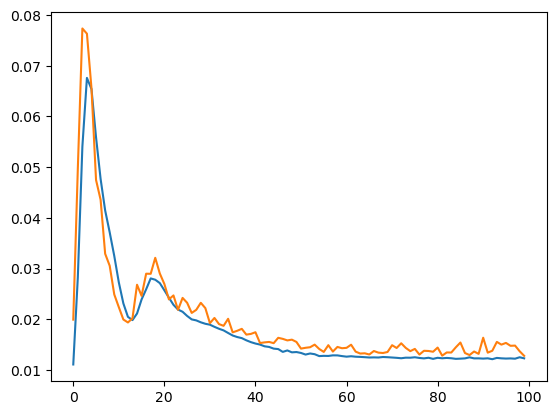

In [71]:
plt.plot(train_losses)
plt.plot(val_losses)

In [73]:
for batch in validation_generator:
    break
output = model(batch[0])
output

tensor([[ 0.9787],
        [-0.9423],
        [-0.9233],
        [-0.6554],
        [ 0.1334],
        [ 0.1411],
        [-0.6245],
        [ 0.1058],
        [-0.2093],
        [ 0.9808],
        [ 0.8234],
        [-0.9179],
        [-0.1344],
        [ 0.7620],
        [-0.0714],
        [ 0.4681],
        [ 0.6722],
        [-0.6146],
        [ 0.9875],
        [-0.1003],
        [ 0.2234],
        [-0.1596],
        [ 0.8841],
        [ 0.0794],
        [ 0.6634],
        [ 0.8898],
        [ 0.2106],
        [ 0.2242],
        [-0.4829],
        [-0.7063],
        [ 0.1647],
        [-0.6401]], grad_fn=<TanhBackward0>)

In [74]:
batch[1]

tensor([[ 0.7989],
        [-0.8072],
        [-0.7906],
        [-0.6441],
        [ 0.0807],
        [ 0.1119],
        [-0.5032],
        [ 0.0614],
        [-0.1138],
        [ 0.8215],
        [ 0.7192],
        [-0.7874],
        [-0.0746],
        [ 0.6052],
        [-0.0384],
        [ 0.4107],
        [ 0.6323],
        [-0.7315],
        [ 0.8775],
        [-0.2053],
        [ 0.2307],
        [-0.1872],
        [ 0.5445],
        [ 0.0198],
        [ 0.6488],
        [ 0.5685],
        [ 0.2255],
        [ 0.1993],
        [-0.4002],
        [-0.5951],
        [ 0.1055],
        [-0.7371]])

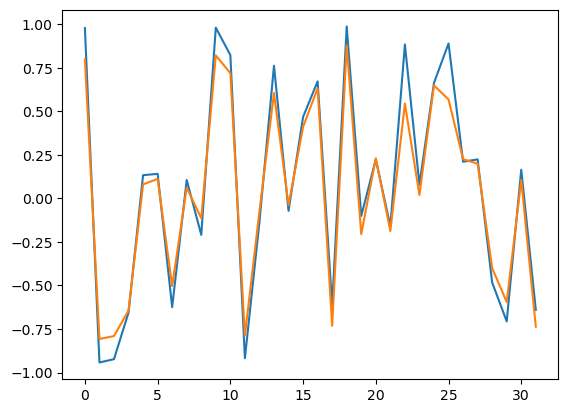

In [75]:
plt.plot(output.detach().numpy())
plt.plot(batch[1].detach().numpy())

In [61]:
0.9**50

0.00515377520732012

In [37]:
del model